In [77]:
!pip install split-folders

In [78]:
# Import các thư viện cần thiết
import tensorflow as tf
import os
import splitfolders
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import load_model
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [79]:
# Đường dẫn folder dataset ban đầu
path = '/kaggle/input/car-vs-bike-classification-dataset/Car-Bike-Dataset'

In [80]:
splitfolders.ratio(path, output='/kaggle/working/output_dataset',
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 4000 files [00:04, 912.96 files/s] 


In [81]:
train_path = '/kaggle/working/output_dataset/train'
test_path = '/kaggle/working/output_dataset/test'
val_path = '/kaggle/working/output_dataset/val'

In [82]:
train_gen = ImageDataGenerator(
    rescale = 1./255,
     horizontal_flip=True,
     vertical_flip=False,
     zoom_range=0.2,
     rotation_range=15,
     shear_range=0.2,    
)
val_gen = ImageDataGenerator(rescale = 1./255)
test_gen = ImageDataGenerator(rescale = 1./255)

train_data = train_gen.flow_from_directory(
    train_path,
    target_size = (224, 224),
    batch_size = 32,
)
val_data = val_gen.flow_from_directory(
    val_path,
    target_size = (224, 224),
    batch_size = 32,
    shuffle=False
)
test_data = test_gen.flow_from_directory(
    test_path,
    target_size = (224, 224),
    batch_size = 1,
    shuffle=False
)

Found 3200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


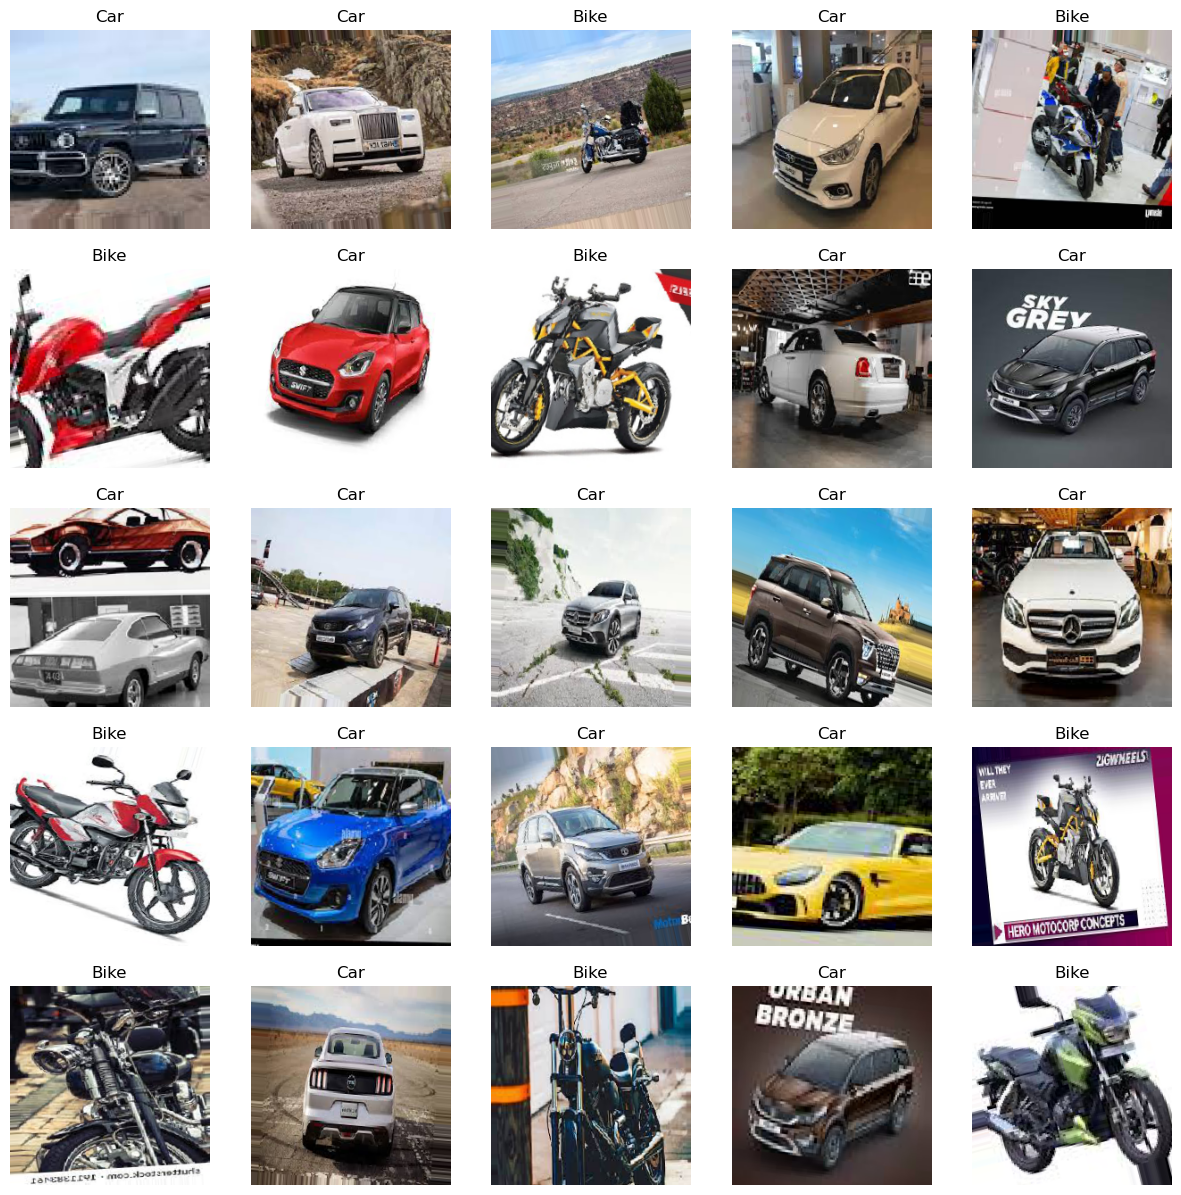

In [83]:
def show_images_samples(gen):
  map = gen.class_indices
  classes = list(map.keys())
  images, labels = next(gen)
  plt.figure(figsize=(15, 15))
  length = len(labels)
  for i in range(25):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image)
    plt.axis('off')
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='black')
  plt.show()
show_images_samples(train_data)

In [84]:
class Vgg16:
  def __init__(self):
    self.model = None
    self.hist = None
  def build(self):
    model = tf.keras.Sequential()
    input = Input(shape=(224, 224, 3))
    vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    vgg16.trainable=True
    model.add(input)
    model.add(vgg16)
    model.add(Flatten())
    model.add(Dense(4096, activation=None))
#     model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    self.model = model
  def train(self, train_data, val_data):
    self.model.compile(SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    self.hist = self.model.fit(train_data, epochs=10, validation_data=val_data)
    
  def feature_extract(self, data):
    feature_extractor = tf.keras.Model(inputs=self.model.inputs, outputs=self.model.layers[-5].output)
    return feature_extractor.predict(data)
  def predict(self, test_data):
    return self.model.predict(test_data)
  def evaluate(self, test_data):
    acc = self.model.evaluate(test_data)
    print('acc: ', acc)
  def summary(self):
    return self.model.summary()
  def plot_acc(self):
    plt.plot(self.hist.history['accuracy'])
    plt.plot(self.hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
  def plot_loss(self):
    plt.plot(self.hist.history['loss'])
    plt.plot(self.hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
  def load(self, path):
    self.model = load_model(path)
  def save(self, path):
    self.model.save(path)

In [85]:
model = Vgg16()
model.build()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_12 (Dense)            (None, 4096)              102764544 
                                                                 
 dense_13 (Dense)            (None, 1024)              4195328   
                                                                 
 dense_14 (Dense)            (None, 512)               524800    
                                                                 
 dense_15 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 122,200,386
Trainable params: 122,200,38

In [86]:
model.train(train_data, val_data)

Epoch 1/10
  3/100 [..............................] - ETA: 46s - loss: 3.5648 - accuracy: 0.4792

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


100/100 [==============================] - 62s 600ms/step - loss: 0.9878 - accuracy: 0.5656 - val_loss: 0.5908 - val_accuracy: 0.7800
Epoch 2/10
100/100 [==============================] - 59s 591ms/step - loss: 0.6588 - accuracy: 0.5872 - val_loss: 0.7172 - val_accuracy: 0.4950
Epoch 3/10
100/100 [==============================] - 60s 596ms/step - loss: 0.6441 - accuracy: 0.6475 - val_loss: 0.6354 - val_accuracy: 0.6275
Epoch 4/10
100/100 [==============================] - 60s 600ms/step - loss: 0.3432 - accuracy: 0.8591 - val_loss: 0.1388 - val_accuracy: 0.9450
Epoch 5/10
100/100 [==============================] - 59s 589ms/step - loss: 0.1383 - accuracy: 0.9488 - val_loss: 0.0600 - val_accuracy: 0.9700
Epoch 6/10
100/100 [==============================] - 59s 590ms/step - loss: 0.0798 - accuracy: 0.9703 - val_loss: 0.0461 - val_accuracy: 0.9825
Epoch 7/10
100/100 [==============================] - 59s 584ms/step - loss: 0.0704 - accuracy: 0.9750 - val_loss: 0.0705 - val_accuracy: 0.9

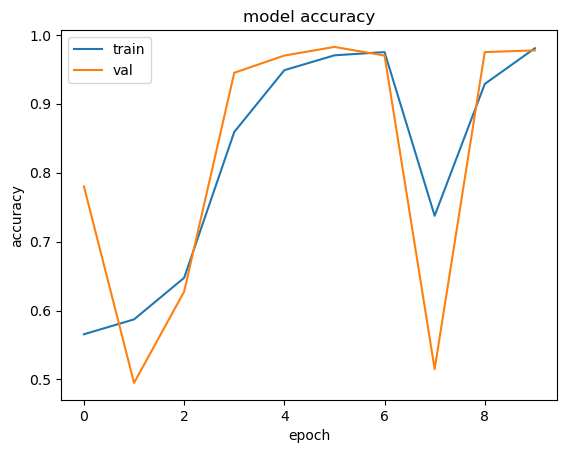

In [87]:
model.plot_acc()

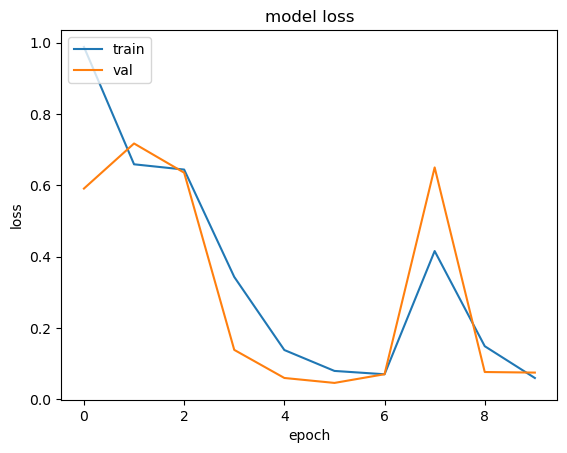

In [88]:
model.plot_loss()

In [89]:
vectors = model.feature_extract(test_data)

400/400 [==============================] - 4s 9ms/step


In [90]:
vectors.shape

(400, 25088)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(vectors, test_data.labels, test_size=0.2, random_state=42)

In [92]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [93]:
svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [94]:
y_pred = svc.predict(X_test)

In [95]:
target = ['Car', 'Bike']
print(classification_report(y_test, y_pred, target_names=target))

              precision    recall  f1-score   support

         Car       0.98      0.91      0.94        44
        Bike       0.90      0.97      0.93        36

    accuracy                           0.94        80
   macro avg       0.94      0.94      0.94        80
weighted avg       0.94      0.94      0.94        80



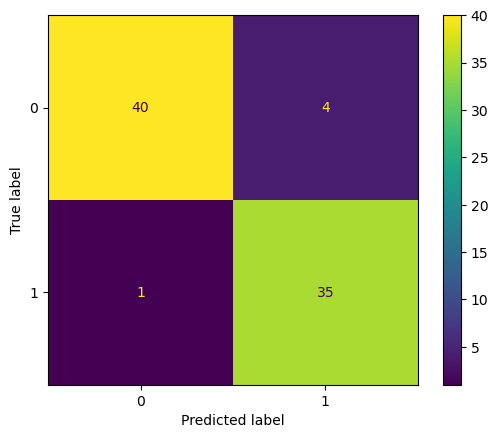

In [96]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()